In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization,Activation
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest')

In [4]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',  # Changed from 'binary' to 'categorical'
                                                    shuffle=True, 
                                                    seed=42, 
                                                    color_mode='rgb')


Found 19674 images belonging to 2 classes.


In [7]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', 
                                                   batch_size=32, 
                                                   target_size=(120,120), 
                                                   class_mode='categorical',
                                                   shuffle=False, 
                                                   seed = 42, 
                                                   color_mode = 'rgb')


Found 2158 images belonging to 2 classes.


In [8]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')


Found 2162 images belonging to 2 classes.


In [9]:
x, y = next(train_generator)
print(f"Shape of batch (X): {x.shape}")
print(f"Shape of labels (Y): {y.shape}")


Shape of batch (X): (32, 120, 120, 3)
Shape of labels (Y): (32, 2)


In [10]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Explicitly define the input shape
input_shape = (120, 120, 3)

# Base Model
base_Neural_Net = DenseNet121(input_shape=input_shape, weights='imagenet', include_top=False)

# Create a Sequential model
model = Sequential()

# Add the base model with pre-trained weights
model.add(base_Neural_Net)

# Freeze the base model layers
for layer in base_Neural_Net.layers:
    layer.trainable = False

# Add custom layers
model.add(Flatten())
model.add(BatchNormalization())  # Add BatchNormalization after Flatten
model.add(Dense(256, kernel_initializer='he_uniform'))
model.add(BatchNormalization())  # Add BatchNormalization before Activation
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Categorical classification output

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

# Print the model summary
model.build((None,120,120,3))  # Manually define input shape for model build
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 3, 3, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 9216)                │          36,864 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,435,458 (35.99 MB)

 Trainable params: 2,379,010 (9.08 MB)

 Non-trainable params: 7,056,448 (26.92 MB)

In [11]:
filepath='model_DenseNet121.keras'
cp = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1, save_best_only=True, save_weights_only=False, mode='max',save_freq='epoch')

In [12]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[es,cp]
)

Epoch 1/10


C:\Users\abhi2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - AUC: 0.7754 - accuracy: 0.7179 - loss: 0.6318
Epoch 1: val_accuracy improved from -inf to 0.87049, saving model to model_DenseNet121.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 907ms/step - AUC: 0.7767 - accuracy: 0.7189 - loss: 0.6298 - val_AUC: 0.9402 - val_accuracy: 0.8705 - val_loss: 0.3123
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - AUC: 0.9297 - accuracy: 0.8544 - loss: 0.3390
Epoch 2: val_accuracy improved from 0.87049 to 0.88529, saving model to model_DenseNet121.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 661ms/step - AUC: 0.9296 - accuracy: 0.8544 - loss: 0.3392 - val_AUC: 0.9583 - val_accuracy: 0.8853 - val_loss: 0.2616
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - AUC: 0.9469 - accuracy: 0.8752 - loss: 0.2945
Epoch 3: val_accuracy improved from 0.88529 to 0.90518, saving model to model_DenseNet121.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 661ms/step - AUC: 0.9470 - accuracy: 0.8754 - loss: 0.2942 - val_AUC: 0.9646 - val_accuracy: 0.

In [13]:
history = model.history.history

In [14]:
import matplotlib.pyplot as plt  # Importing the necessary library

def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


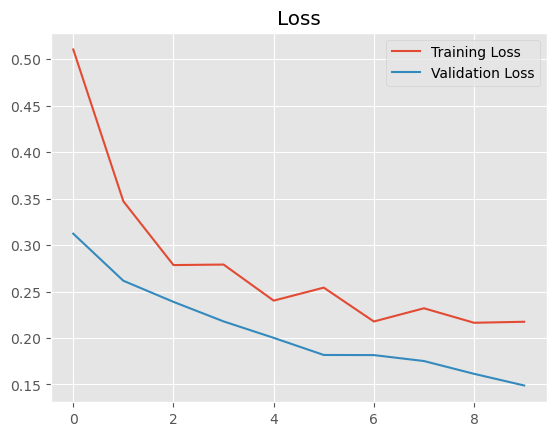

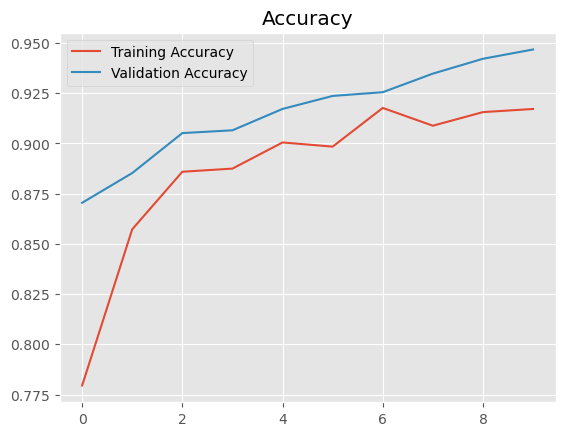

In [15]:
plot_metrics(history) 

In [16]:
from tensorflow.keras.models import Model, load_model
best_model_1=load_model("model_DenseNet121.keras")
best_model_1.metrics_names

['loss', 'compile_metrics']

In [17]:
metrics = best_model_1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
auc = metrics[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}')

68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 346ms/step - AUC: 0.9907 - accuracy: 0.9510 - loss: 0.1288
Loss: 0.1513013392686844, Accuracy: 0.9406858086585999, AUC: 0.986552357673645


In [18]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.1513013392686844
Test Accuracy = 0.9406858086585999


In [24]:
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

# Base Model
base_Neural_Net = DenseNet121(input_shape=(120, 120, 3), weights='imagenet', include_top=False)

for layer in base_Neural_Net.layers:
    layer.trainable = False

for layer in base_Neural_Net.layers:
    if layer.name.startswith("conv5_block16") or layer.name.startswith("conv5_block15"):
        layer.trainable = True

for layer in base_Neural_Net.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Create a Sequential model
model_1 = Sequential()
model_1.add(base_Neural_Net)
model_1.add(Flatten())
model_1.add(BatchNormalization())
model_1.add(Dense(256, kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(2, activation='softmax'))  # Categorical classification output

# Compile the model with a smaller learning rate for fine-tuning
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for fine-tuning
    metrics=['accuracy', 'AUC']
)

model_1.build((None, 120, 120, 3))

# Print the model summary
model_1.summary()



input_layer_8: Trainable = False
zero_padding2d_10: Trainable = False
conv1_conv: Trainable = False
conv1_bn: Trainable = False
conv1_relu: Trainable = False
zero_padding2d_11: Trainable = False
pool1: Trainable = False
conv2_block1_0_bn: Trainable = False
conv2_block1_0_relu: Trainable = False
conv2_block1_1_conv: Trainable = False
conv2_block1_1_bn: Trainable = False
conv2_block1_1_relu: Trainable = False
conv2_block1_2_conv: Trainable = False
conv2_block1_concat: Trainable = False
conv2_block2_0_bn: Trainable = False
conv2_block2_0_relu: Trainable = False
conv2_block2_1_conv: Trainable = False
conv2_block2_1_bn: Trainable = False
conv2_block2_1_relu: Trainable = False
conv2_block2_2_conv: Trainable = False
conv2_block2_concat: Trainable = False
conv2_block3_0_bn: Trainable = False
conv2_block3_0_relu: Trainable = False
conv2_block3_1_conv: Trainable = False
conv2_block3_1_bn: Trainable = False
conv2_block3_1_relu: Trainable = False
conv2_block3_2_conv: Trainable = False
conv2_block3

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 3, 3, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 9216)                │          36,864 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,435,458 (35.99 MB)

 Trainable params: 2,707,010 (10.33 MB)

 Non-trainable params: 6,728,448 (25.67 MB)

In [25]:
EPOCHS = 10
est = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=8
)

history_01 = model_1.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[est,cp]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - AUC: 0.7731 - accuracy: 0.7127 - loss: 0.6890
Epoch 1: val_accuracy did not improve from 0.95375
60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 686ms/step - AUC: 0.7744 - accuracy: 0.7137 - loss: 0.6865 - val_AUC: 0.9414 - val_accuracy: 0.8742 - val_loss: 0.3152
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - AUC: 0.9324 - accuracy: 0.8544 - loss: 0.3442
Epoch 2: val_accuracy did not improve from 0.95375
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 699ms/step - AUC: 0.9325 - accuracy: 0.8546 - loss: 0.3440 - val_AUC: 0.9640 - val_accuracy: 0.9066 - val_loss: 0.2441
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - AUC: 0.9393 - accuracy: 0.8737 - loss: 0.3226
Epoch 3: val_accuracy did not improve from 0.95375
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 694ms/step - AUC: 0.9394 - accuracy: 0.8738 - loss: 0.3224 - val_AUC: 0.9645 - val_accuracy: 0.9038 - val_loss: 0.2423
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - AUC: 0.9546 - accuracy: 0.8867 - loss: 0.28

In [26]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

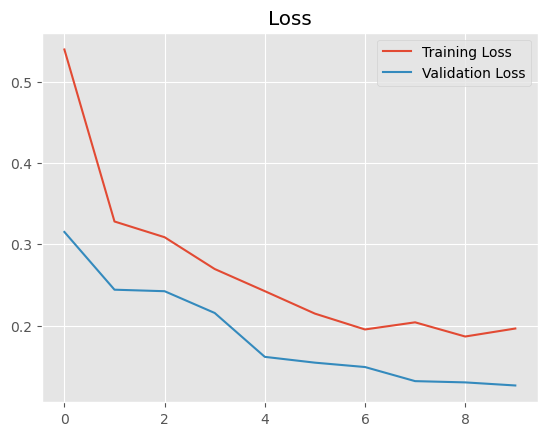

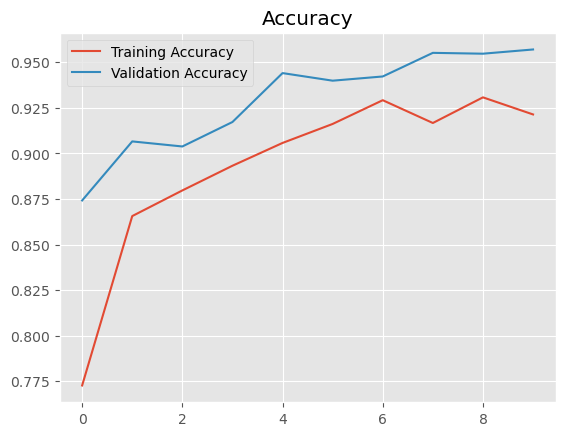

In [27]:
plot_metrics(history_01) 

In [28]:
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

# Base Model
base_Neural_Net = DenseNet121(input_shape=(120, 120, 3), weights='imagenet', include_top=False)

for layer in base_Neural_Net.layers:
    layer.trainable = True

for layer in base_Neural_Net.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Create a Sequential model
model_1 = Sequential()
model_1.add(base_Neural_Net)
model_1.add(Flatten())
model_1.add(BatchNormalization())
model_1.add(Dense(256, kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(2, activation='softmax'))  # Categorical classification output

# Compile the model with a smaller learning rate for fine-tuning
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for fine-tuning
    metrics=['accuracy', 'AUC']
)

model_1.build((None, 120, 120, 3))

# Print the model summary
model_1.summary()

input_layer_10: Trainable = True
zero_padding2d_12: Trainable = True
conv1_conv: Trainable = True
conv1_bn: Trainable = True
conv1_relu: Trainable = True
zero_padding2d_13: Trainable = True
pool1: Trainable = True
conv2_block1_0_bn: Trainable = True
conv2_block1_0_relu: Trainable = True
conv2_block1_1_conv: Trainable = True
conv2_block1_1_bn: Trainable = True
conv2_block1_1_relu: Trainable = True
conv2_block1_2_conv: Trainable = True
conv2_block1_concat: Trainable = True
conv2_block2_0_bn: Trainable = True
conv2_block2_0_relu: Trainable = True
conv2_block2_1_conv: Trainable = True
conv2_block2_1_bn: Trainable = True
conv2_block2_1_relu: Trainable = True
conv2_block2_2_conv: Trainable = True
conv2_block2_concat: Trainable = True
conv2_block3_0_bn: Trainable = True
conv2_block3_0_relu: Trainable = True
conv2_block3_1_conv: Trainable = True
conv2_block3_1_bn: Trainable = True
conv2_block3_1_relu: Trainable = True
conv2_block3_2_conv: Trainable = True
conv2_block3_concat: Trainable = True


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 3, 3, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 9216)                │          36,864 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,435,458 (35.99 MB)

 Trainable params: 9,332,866 (35.60 MB)

 Non-trainable params: 102,592 (400.75 KB)

In [29]:
EPOCHS = 10
est = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=8
)

history_01 = model_1.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[est,cp]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6848 - accuracy: 0.6302 - loss: 0.7824
Epoch 1: val_accuracy did not improve from 0.95698
60/60 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - AUC: 0.6872 - accuracy: 0.6321 - loss: 0.7788 - val_AUC: 0.9425 - val_accuracy: 0.8636 - val_loss: 0.3411
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9621 - accuracy: 0.9039 - loss: 0.2521
Epoch 2: val_accuracy did not improve from 0.95698
60/60 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - AUC: 0.9621 - accuracy: 0.9038 - loss: 0.2521 - val_AUC: 0.9423 - val_accuracy: 0.8682 - val_loss: 0.3639
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9879 - accuracy: 0.9420 - loss: 0.1404
Epoch 3: val_accuracy did not improve from 0.95698
60/60 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - AUC: 0.9880 - accuracy: 0.9421 - loss: 0.1402 - val_AUC: 0.9804 - val_accuracy: 0.9292 - val_loss: 0.1888
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9870 - accuracy: 0.9404 - loss: 0.1390
Epoch 4: val_ac

In [30]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

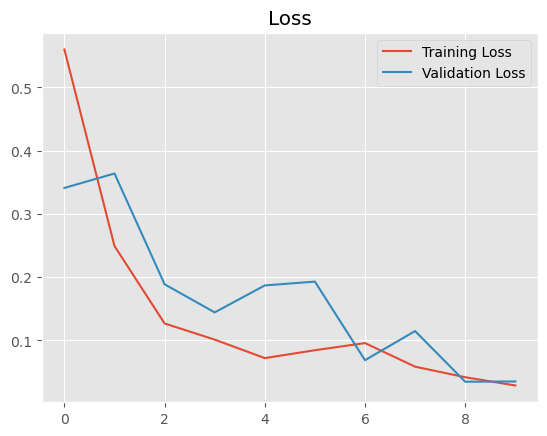

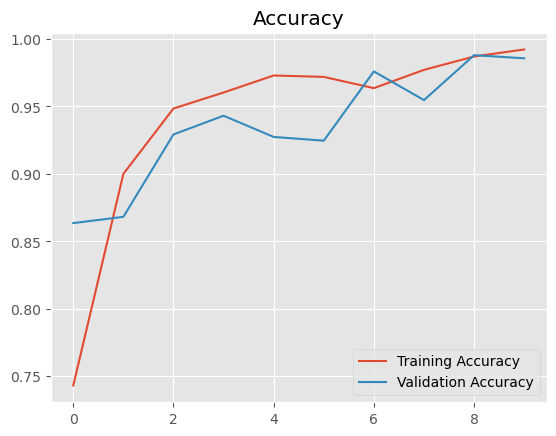

In [31]:
plot_metrics(history_01) 

In [9]:
from tensorflow.keras.models import Model, load_model
model_1=load_model("model_DenseNet121.keras")
model_1.metrics_names

['loss', 'compile_metrics']

In [10]:
metrics = model_1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
auc = metrics[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}')

C:\Users\abhi2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 296ms/step - AUC: 0.9993 - accuracy: 0.9910 - loss: 0.0286
Loss: 0.036726873368024826, Accuracy: 0.9884151816368103, AUC: 0.9987173676490784


In [11]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.036726873368024826
Test Accuracy = 0.9884151816368103


In [12]:
nb_samples = test_generator.samples

In [13]:
print("True labels shape:", test_generator.classes.shape)
print("Unique true labels:", np.unique(test_generator.classes))

True labels shape: (2158,)
Unique true labels: [0 1]


In [15]:
# Check predictions
predictions = model_1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

print("Predicted labels shape:", predicted_labels.shape)
print("Unique predicted labels:", np.unique(predicted_labels))

68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 353ms/step
Predicted labels shape: (2158,)
Unique predicted labels: [0 1]


In [16]:
predicted_probabilities = model_1.predict(test_generator)[:, 1]

# Set a custom threshold
threshold = 0.5  # Change this value to experiment
adjusted_predictions = (predicted_probabilities >= threshold).astype(int)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_generator.classes, adjusted_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, adjusted_predictions))

68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step
Confusion Matrix:
 [[1066   13]
 [  18 1061]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1079
           1       0.99      0.98      0.99      1079

    accuracy                           0.99      2158
   macro avg       0.99      0.99      0.99      2158
weighted avg       0.99      0.99      0.99      2158

